In [1]:
!pip install datasets

     |████████████████████████████████| 298 kB 5.3 MB/s 
     |████████████████████████████████| 61 kB 634 kB/s 
     |████████████████████████████████| 1.1 MB 56.4 MB/s 
     |████████████████████████████████| 132 kB 73.9 MB/s 
     |████████████████████████████████| 243 kB 71.4 MB/s 
     |████████████████████████████████| 271 kB 73.1 MB/s 
     |████████████████████████████████| 192 kB 73.4 MB/s 
     |████████████████████████████████| 160 kB 62.7 MB/s 


In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from gensim.utils import simple_preprocess
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from datasets import load_dataset

## Load Hugging Face Dataset

In [3]:
dataset = load_dataset("sst", "default")

Downloading:   0%|          | 0.00/2.59k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.37M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset sst downloaded and prepared to /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
x_train = [member['sentence'] for member in dataset['train']]
y_train = [member['label'] for member in dataset['train']]

x_val = [member['sentence'] for member in dataset['validation']]
y_val = [member['label'] for member in dataset['validation']]

x_test = [member['sentence'] for member in dataset['test']]
y_test = [member['label'] for member in dataset['test']]

## Vectorize Data

In [5]:
vocab_size = 20000
maxlen = 100

vectorize_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=maxlen,
    output_mode='int')

vectorize_layer.adapt(x_train+x_val)

In [6]:
x_train = vectorize_layer(tf.expand_dims(x_train, -1))
x_val = vectorize_layer(tf.expand_dims(x_val, -1))

y_train = np.array(y_train)
y_val = np.array(y_val)

y_train = np.round(y_train)
y_val = np.round(y_val)

## USE Embedding Layer

In [7]:
voc = vectorize_layer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [8]:
# get USE embedding index
embedding_index = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# create embedding matrix
num_tokens = len(voc) + 2
embedding_dim = 512
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index([word])
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

## Attention Neural Network Architectures

In [9]:
class PositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(PositionEmbedding, self).__init__()
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim, trainable=True)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return positions

In [10]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, key_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [11]:
# create sinusiodal positional encoding layer
positional_encoding_layer = np.zeros((maxlen, embedding_dim))
position = np.arange(0, maxlen)
position = np.expand_dims(position, 1)
div_term = np.exp(np.arange(0, embedding_dim, 2) * (-math.log(10000.0) / embedding_dim))
positional_encoding_layer[:, 0::2] = np.sin(position * div_term)
positional_encoding_layer[:, 1::2] = np.cos(position * div_term)
sinusiodal_positional_encoding_layer = np.expand_dims(positional_encoding_layer, 0)

In [12]:
class AttentionModel(tf.keras.Model):

    def __init__(self, vocab_size, embedding_dim, positional_type=None, use_residual=False, use_transformer_block=False):
        super(AttentionModel, self).__init__()

        self.use_transformer_block = use_transformer_block

        self.use_residual = use_residual

        self.positional_type=positional_type
        
        self.embedding = layers.Embedding(vocab_size,
                                        embedding_dim,
                                        embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                        trainable=False,
                                    )
        
        if positional_type=='learned':
          self.positional = PositionEmbedding(maxlen=maxlen,
                                            vocab_size=vocab_size,
                                            embed_dim=embedding_dim)
        
        elif positional_type=='sinusoidal':
          self.positional = sinusiodal_positional_encoding_layer

        if use_transformer_block:
          self.transformer_encoder = TransformerBlock(embed_dim=embedding_dim,
                                                      key_dim=128,
                                                      num_heads=4,
                                                      ff_dim=512,
                                                      rate=0.1)
        else:
          self.attention = layers.MultiHeadAttention(num_heads=1, key_dim=512)
          self.dropout1 = layers.Dropout(0.1)
          self.layernorm = layers.LayerNormalization(epsilon=1e-6)

        self.pooling = layers.GlobalAveragePooling1D()
        self.dropout2 = layers.Dropout(0.1)
        self.dense = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training):
        
        if self.positional_type is None:
          token_embeddings = self.embedding(inputs)
          
        elif self.positional_type=='learned':
          token_embeddings = self.embedding(inputs) + self.positional(inputs)

        elif self.positional_type=='sinusoidal':
          token_embeddings = self.embedding(inputs)
          mask = inputs == 0
          mask = tf.expand_dims(mask, 2)
          mask = tf.tile(mask, tf.constant([1, 1, 512]))
          self.token_embeddings = tf.where(mask, token_embeddings, token_embeddings + self.positional)

        if self.use_transformer_block:
          contextualized_embeddings = self.transformer_encoder(token_embeddings)
        else:
          contextualized_embeddings = self.attention(token_embeddings, token_embeddings)
          contextualized_embeddings = self.dropout1(contextualized_embeddings, training=training)

          if self.use_residual:
            contextualized_embeddings = self.layernorm(token_embeddings + contextualized_embeddings)
          else:
            contextualized_embeddings = self.layernorm(contextualized_embeddings)

        combined_embedding = self.pooling(contextualized_embeddings)
        combined_embedding = self.dropout2(combined_embedding, training=training) 


        output = self.dense(combined_embedding)
        
        return output

In [13]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [14]:
def createAttentionModel(positional_type=None,
                         use_custom_schedule = False,
                         warmup_steps=4000,
                         use_residual=False,
                         learning_rate=None,
                         use_transformer_block=False):

  model = AttentionModel(vocab_size=num_tokens,
                         embedding_dim=embedding_dim,
                         positional_type=positional_type,
                         use_residual=use_residual,
                         use_transformer_block=False)

  if not use_custom_schedule:
    print('Optimizer: using regular Adam')
    optimizer="adam"
    
  else:
    print('Optimizer: using custom schedule Adam')
    if learning_rate is None:
      learning_rate = CustomSchedule(embedding_dim, warmup_steps)
      optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate)
      print("Optimizer: using regular adam with custom learning rate")
    
  model.compile(optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=["accuracy"])


  model.build(x_train.shape)
  model.summary()

  return model

## Train Models

In [15]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

### 1. Attention Model - No Positional Embeddings


In [16]:
attn_model_no_positional = createAttentionModel()

Optimizer: using regular Adam
Model: "attention_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  8946176   
                                                                 
 multi_head_attention (Multi  multiple                 1050624   
 HeadAttention)                                                  
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 layer_normalization (LayerN  multiple                 1024      
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  multiple                 0         
 lobalAveragePooling1D)                                          
                     

In [17]:
history = attn_model_no_positional.fit(x_train,
                                        y_train,
                                        epochs=10,
                                        validation_data=(x_val, y_val)
)

Epoch 1/10
267/267 [==============================] - 3s 9ms/step - loss: 0.8466 - accuracy: 0.5018 - val_loss: 0.7018 - val_accuracy: 0.5068
Epoch 2/10
267/267 [==============================] - 2s 8ms/step - loss: 0.6210 - accuracy: 0.6410 - val_loss: 0.5415 - val_accuracy: 0.7212
Epoch 3/10
267/267 [==============================] - 2s 8ms/step - loss: 0.5296 - accuracy: 0.7347 - val_loss: 0.5699 - val_accuracy: 0.7302
Epoch 4/10
267/267 [==============================] - 2s 8ms/step - loss: 0.5187 - accuracy: 0.7390 - val_loss: 0.5055 - val_accuracy: 0.7466
Epoch 5/10
267/267 [==============================] - 2s 8ms/step - loss: 0.5073 - accuracy: 0.7443 - val_loss: 0.5704 - val_accuracy: 0.7284
Epoch 6/10
267/267 [==============================] - 2s 8ms/step - loss: 0.5017 - accuracy: 0.7500 - val_loss: 0.5130 - val_accuracy: 0.7548
Epoch 7/10
267/267 [==============================] - 2s 8ms/step - loss: 0.4923 - accuracy: 0.7614 - val_loss: 0.5235 - val_accuracy: 0.7520
Epoch 

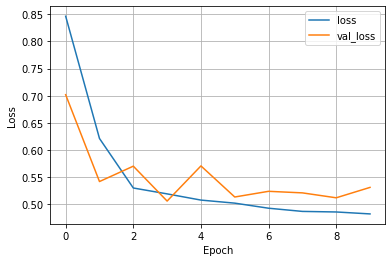

In [18]:
plot_loss(history)

### 2. Attention Model - Learned Positional Embeddings


In [19]:
attn_model_learned_positional = createAttentionModel(positional_type='learned')

Optimizer: using regular Adam
Model: "attention_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  8946176   
                                                                 
 position_embedding (Positio  multiple                 51200     
 nEmbedding)                                                     
                                                                 
 multi_head_attention_1 (Mul  multiple                 1050624   
 tiHeadAttention)                                                
                                                                 
 dropout_2 (Dropout)         multiple                  0         
                                                                 
 layer_normalization_1 (Laye  multiple                 1024      
 rNormalization)                                                 
                   

In [20]:
history = attn_model_learned_positional.fit(x_train,
                                            y_train,
                                            epochs=10,
                                            validation_data=(x_val, y_val)
)

Epoch 1/10
267/267 [==============================] - 3s 10ms/step - loss: 0.8053 - accuracy: 0.4999 - val_loss: 0.6935 - val_accuracy: 0.5068
Epoch 2/10
267/267 [==============================] - 2s 9ms/step - loss: 0.6940 - accuracy: 0.5434 - val_loss: 0.7072 - val_accuracy: 0.5322
Epoch 3/10
267/267 [==============================] - 2s 9ms/step - loss: 0.6400 - accuracy: 0.6366 - val_loss: 0.5941 - val_accuracy: 0.6857
Epoch 4/10
267/267 [==============================] - 2s 9ms/step - loss: 0.5718 - accuracy: 0.7006 - val_loss: 0.6574 - val_accuracy: 0.6312
Epoch 5/10
267/267 [==============================] - 2s 9ms/step - loss: 0.5565 - accuracy: 0.7121 - val_loss: 0.5405 - val_accuracy: 0.7393
Epoch 6/10
267/267 [==============================] - 2s 9ms/step - loss: 0.5364 - accuracy: 0.7309 - val_loss: 0.5367 - val_accuracy: 0.7212
Epoch 7/10
267/267 [==============================] - 2s 9ms/step - loss: 0.5307 - accuracy: 0.7326 - val_loss: 0.5713 - val_accuracy: 0.7103
Epoch

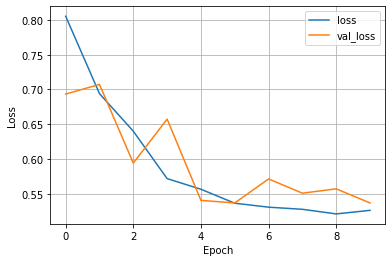

In [21]:
plot_loss(history)

### 3. Attention Model - Sinusoidal Positional Embeddings


In [22]:
attn_model_sinusoidal_positional = createAttentionModel(positional_type='sinusoidal', use_custom_schedule=True)
#attn_model_sinusoidal_positional = createAttentionModel(positional_type='sinusoidal', learning_rate=0.001)

Optimizer: using custom schedule Adam
Model: "attention_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  8946176   
                                                                 
 multi_head_attention_2 (Mul  multiple                 1050624   
 tiHeadAttention)                                                
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 layer_normalization_2 (Laye  multiple                 1024      
 rNormalization)                                                 
                                                                 
 global_average_pooling1d_2   multiple                 0         
 (GlobalAveragePooling1D)                                        
           

In [23]:
history = attn_model_sinusoidal_positional.fit(x_train,
                                            y_train,
                                            ########################## I changed it from 100 to 15 to make it run faster
                                            epochs=15,
                                            validation_data=(x_val, y_val)
)

Epoch 1/15
267/267 [==============================] - 3s 9ms/step - loss: 0.7351 - accuracy: 0.5082 - val_loss: 0.6943 - val_accuracy: 0.4932
Epoch 2/15
267/267 [==============================] - 2s 8ms/step - loss: 0.6951 - accuracy: 0.5488 - val_loss: 0.5845 - val_accuracy: 0.6885
Epoch 3/15
267/267 [==============================] - 2s 8ms/step - loss: 0.5764 - accuracy: 0.6921 - val_loss: 0.5387 - val_accuracy: 0.7375
Epoch 4/15
267/267 [==============================] - 2s 8ms/step - loss: 0.5498 - accuracy: 0.7237 - val_loss: 0.5567 - val_accuracy: 0.7048
Epoch 5/15
267/267 [==============================] - 2s 8ms/step - loss: 0.5336 - accuracy: 0.7292 - val_loss: 0.5377 - val_accuracy: 0.7166
Epoch 6/15
267/267 [==============================] - 2s 8ms/step - loss: 0.5163 - accuracy: 0.7403 - val_loss: 0.5644 - val_accuracy: 0.7193
Epoch 7/15
267/267 [==============================] - 2s 8ms/step - loss: 0.5072 - accuracy: 0.7470 - val_loss: 0.5123 - val_accuracy: 0.7511
Epoch 

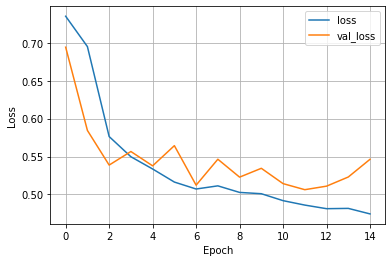

In [24]:
 plot_loss(history)

In [25]:
!pip install bertviz

     |████████████████████████████████| 156 kB 4.9 MB/s 
     |████████████████████████████████| 131 kB 29.3 MB/s 
     |████████████████████████████████| 3.1 MB 30.1 MB/s 
     |████████████████████████████████| 1.2 MB 62.9 MB/s 
     |████████████████████████████████| 895 kB 59.9 MB/s 
     |████████████████████████████████| 596 kB 62.8 MB/s 
     |████████████████████████████████| 3.3 MB 57.5 MB/s 
     |████████████████████████████████| 79 kB 10.0 MB/s 
     |████████████████████████████████| 8.4 MB 58.5 MB/s 
     |████████████████████████████████| 138 kB 74.7 MB/s 
     |████████████████████████████████| 127 kB 78.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take

In [26]:
key_list = list(word_index.keys())

In [52]:
import matplotlib.ticker as ticker
from matplotlib.ticker import MaxNLocator
import torch
from bertviz import head_view


'''
visualize attension layer for the given input text (self attention or attention between two sentences) using matplotlib
'''

class Attension_visulaizer():


  def __init__(self,embedding_layer,trained_attention_layer, pos_emb = None, sinusiodal_positional_encoding_layer = None,sin = False):
    self.sin = sin
    self.embedding_layer = embedding_layer
    self.trained_attention_layer = trained_attention_layer
    self.pos_emb = pos_emb
    self.sinusiodal_positional_encoding_layer = sinusiodal_positional_encoding_layer

  # #get model layer by index
  # def get_model_layer(self, idx):

  #   return self.model.get_layer(index=idx)
  #   #return self.model

  #turn text to number
  def vectorize(self,sentence):

    return vectorize_layer(sentence)

  #tokenize the text and add sepcial tokens 
  def tokenizer(self,sentence):

    vectorized_text = vectorize_layer(sentence)
    # print("vectorized_text",vectorized_text)
    actual_text = [key_list[ind] for ind in vectorized_text if key_list[ind]!=""]
    # print("actual_text",actual_text)
    return actual_text

  def get_emb_sinusiodal_out(self,token_embeddings,sinusiodal_positional_encoding_layer,input):

    token = token_embeddings(input)
    print("token",token.shape)

    mask = token_embeddings(input) == 0

    print("mask",mask.shape)
    print("sinusiodal_positional_encoding_layer",sinusiodal_positional_encoding_layer.shape)
    mask1 = tf.expand_dims(mask, 2)

    mask1 = tf.tile(mask1, tf.constant([1, 1, 512]))

    return tf.where(mask, token, token + sinusiodal_positional_encoding_layer)



 #get the output of a sentence from embedding layer 
  def embedding(self,sentence):

    # we just want to visualzie non-padding elements
    non_zero = len(self.tokenizer(sentence))

    # embedding_layer = self.get_model_layer(0)
    if(self.pos_emb == None and self.sin == False):
      embedded_text =  self.embedding_layer(self.vectorize(sentence)[:non_zero])
    elif(self.sin == False): 
      embedded_text =  self.embedding_layer(self.vectorize(sentence)[:non_zero]) + self.pos_emb(self.vectorize(sentence)[:non_zero])
      print("&&&&&&&&&&&&&&&&&&",embedded_text.shape)
    elif(self.sin ==True):
      embedded_text = self.get_emb_sinusiodal_out(self.embedding_layer,sinusiodal_positional_encoding_layer[:,:non_zero],self.vectorize(sentence)[:non_zero] )
      embedded_text = tf.squeeze(embedded_text,0)
      print("&&&&&&&&&&&&&&&&&&",embedded_text.shape)


    return tf.expand_dims(embedded_text, axis=0)

  def attention(self, sentence1, sentence2):

    # trained_attention_layer = self.get_model_layer(1)
    
    embedded_text1 = self.embedding(sentence1)
    embedded_text2 = self.embedding(sentence2)

    print("embedded_text1",embedded_text1.shape)
    print("embedded_text2",embedded_text2.shape)


    output_tensor, attn_weights = self.trained_attention_layer(embedded_text1, embedded_text2, return_attention_scores=True)

    return output_tensor,attn_weights

  @staticmethod
  def attention_numpy(attn_weights ):

    return attn_weights.numpy()


  @staticmethod
  def attention_torch(attn_weights ):

    return torch.tensor(Attension_visulaizer.attention_numpy(attn_weights ))


  
  def evaluateAndShowAttention(self,sentence1, sentence2 =None, attension_heads = None,msg = ''):

    if sentence2 == None:
      sentence2 = sentence1

    #computing the attention weights between two sentences *** we discart the attension weights if sentence length is less than max_len***
    print("sentence1",len(sentence1))  
    output_tensor,attn_weights = self.attention(sentence1,sentence2)
    print("output_tensor",output_tensor.shape)  

    tkn_sen1 = self.tokenizer(sentence1)
    tkn_sen2 = self.tokenizer(sentence2)

    #attention weights for visualization should be in numpy
    attentions_numpy = Attension_visulaizer.attention_numpy(attn_weights)

    print("attn_weights",attn_weights.shape)
    
    # just squeez the first dimension to plot it using showAttention function
    attentions_numpy1 = attentions_numpy.transpose((0, 2,3,1))[0,:,:,:]

    self.showAttention(tkn_sen1, tkn_sen2, attentions_numpy1,attension_heads,msg)

    self.attention_head(attentions_numpy,tkn_sen1)

    self.head_view(attentions_numpy,tkn_sen1)

    # return  output_tensor,attn_weights

  def showAttention(self,input_sentence, output_words, attentions,attension_heads = None,msg = ""):

    if attension_heads != None:

      w = attentions[:,:,attension_heads]
      plt_range = 1


    else:

       w = attentions
       plt_range = w.shape[2]
    
    print(w[1].shape)
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (2*len(input_sentence), 2*len(output_words)), facecolor = "w")

    for i in range(plt_range):
      print(i)
      axes[i].imshow(w[:,:,i])
      axes[i].set_yticks(np.arange(len(input_sentence)))
      axes[i].set_yticklabels(input_sentence)
      axes[i].set_xticks(np.arange(len(input_sentence)))
      axes[i].set_xticklabels(input_sentence)
      axes[i].set_title(msg)
      plt.setp(axes[i].get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
      
    plt.show()

  from bertviz import head_view
 
  def attention_head(self,attention_w,actual_text):
    attension_heads = []
    attention = torch.tensor(attention_w)

    for i in range(attention.shape[1]):

      attension_heads.append(attention[:,i:i+1,:,:])

    # attension_heads = (attention[:,0:1,:,:],attention[:,1:2,:,:],attention[:,2:3,:,:],attention[:,3:4,:,:])
    attension_heads = tuple(attension_heads)

    # print("8888888888",attension_heads)

    # different_heads but this function is for different layer

    head_view(attension_heads, actual_text)

  
  def head_view(self,attention_w,actual_text):

    attention = torch.tensor(attention_w)

    head_view((attention,), actual_text)


In [36]:
import random

def randomized_text(x_train):
  # Random Example Text
  rnd = random.randint(0,x_train.shape[0])
  vectorized_text = x_train[rnd]
  print("vectorized_text",vectorized_text)

  # key_list = list(word_index.keys())
  actual_text = [key_list[ind] for ind in vectorized_text]
  text = " ".join(actual_text)
  print(text)

  return text, y_train[rnd]

text, label = randomized_text(x_train)

print("label",label)

vectorized_text tf.Tensor(
[ 149  954 1990   33   20  232 1203    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)
feels strangely hollow at its emotional core                                                                                             
label 0.0


In [62]:
import random

text = "this is a movie that I would not watch it again"

def random_text(text):
  # Random Example Text
  vectorized_text =vectorize_layer(text)
  print("vectorized_text",vectorized_text)

  # key_list = list(word_index.keys())
  actual_text = [key_list[ind] for ind in vectorized_text]
  text = " ".join(actual_text)
  print(text)

  return text

text = random_text(text)



vectorized_text tf.Tensor(
[ 17   8   3  18  10  39  85  25 207   9 244   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0], shape=(100,), dtype=int64)
this is a movie that i would not watch it again                                                                                         


In [63]:

def get_no_positional(model):
  
  # attn_no_positional = model.transformer_encoder.att
  attn_no_positional = model.attention

  
  emb_no_positional= model.embedding

  return emb_no_positional,attn_no_positional


emb, attention =get_no_positional(attn_model_no_positional)

attn_model_no_positional.predict(vectorize_layer(tf.expand_dims(text,0)))

array([[0.26122105]], dtype=float32)

sentence1 136
embedded_text1 (1, 11, 512)
embedded_text2 (1, 11, 512)
output_tensor (1, 11, 512)
attn_weights (1, 1, 11, 11)
(11, 1)
0


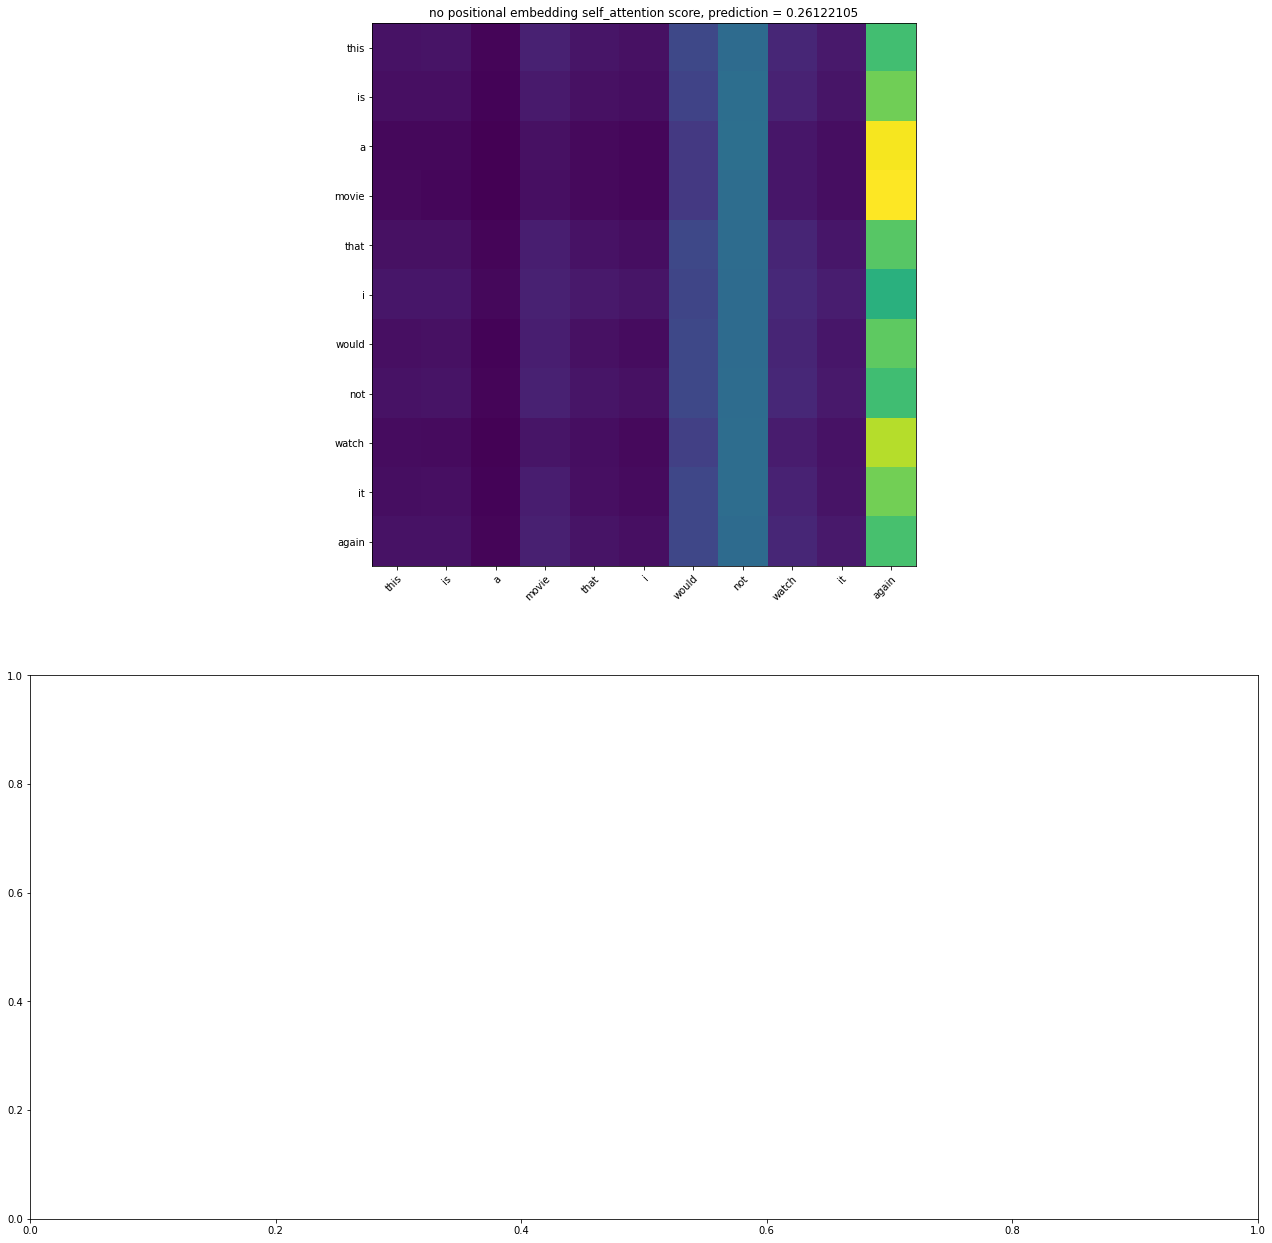

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [69]:
import matplotlib.pyplot as plt
#https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


# attn_no_positional = attn_model_no_positional.get_model_layer(1)
vis = Attension_visulaizer(emb, attention)
actual_text = text
vis.evaluateAndShowAttention(actual_text, attension_heads = None, msg = "no positional embedding self_attention score, prediction = 0.26122105")

In [70]:
def get_learned_positional(model):

  # att = model.transformer_encoder.att
  att = model.attention
  emb = model.embedding
  pos_emb = model.positional

  return emb,pos_emb,att

emb,pos_emb,att = get_learned_positional(attn_model_learned_positional)
attn_model_learned_positional.predict(vectorize_layer(tf.expand_dims(text,0)))

array([[0.38712123]], dtype=float32)

sentence1 136
&&&&&&&&&&&&&&&&&& (11, 512)
&&&&&&&&&&&&&&&&&& (11, 512)
embedded_text1 (1, 11, 512)
embedded_text2 (1, 11, 512)
output_tensor (1, 11, 512)
attn_weights (1, 1, 11, 11)
(11, 1)
0


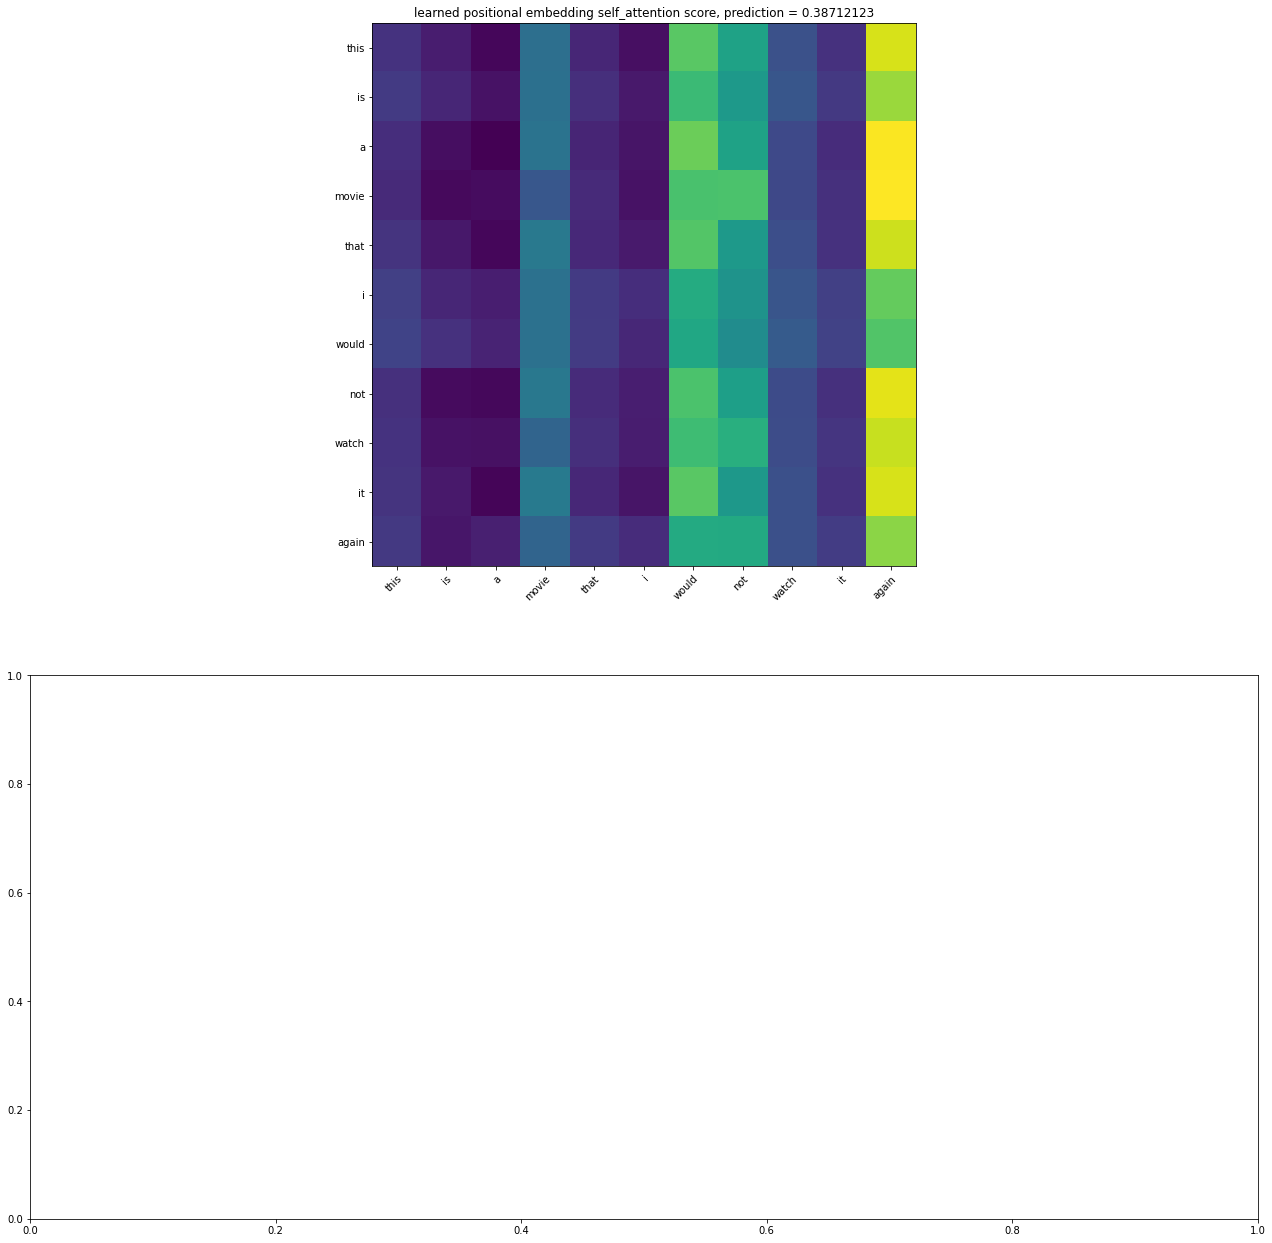

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [68]:
import matplotlib.pyplot as plt
#https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


# attn_no_positional = attn_model_no_positional.get_model_layer(1)

# emb,pos_emb,att
vis = Attension_visulaizer(emb, att,pos_emb = pos_emb)
actual_text = text
vis.evaluateAndShowAttention(actual_text, attension_heads = None,msg = "learned positional embedding self_attention score, prediction = 0.38712123")

In [59]:
def get_sinusiodal_emb(model):

  # token_embeddings = attn_model_sinusoidal_positional.embedding
  token_embeddings = model.embedding
  # att = model.transformer_encoder.att
  att = model.attention

  return token_embeddings,att

token_embeddings,att = get_sinusiodal_emb(attn_model_sinusoidal_positional)

attn_model_sinusoidal_positional.predict(vectorize_layer(tf.expand_dims(text,0)))

array([[0.2668989]], dtype=float32)

sentence1 136
token (11, 512)
mask (11, 512)
sinusiodal_positional_encoding_layer (1, 11, 512)
&&&&&&&&&&&&&&&&&& (11, 512)
token (11, 512)
mask (11, 512)
sinusiodal_positional_encoding_layer (1, 11, 512)
&&&&&&&&&&&&&&&&&& (11, 512)
embedded_text1 (1, 11, 512)
embedded_text2 (1, 11, 512)
output_tensor (1, 11, 512)
attn_weights (1, 1, 11, 11)
(11, 1)
0


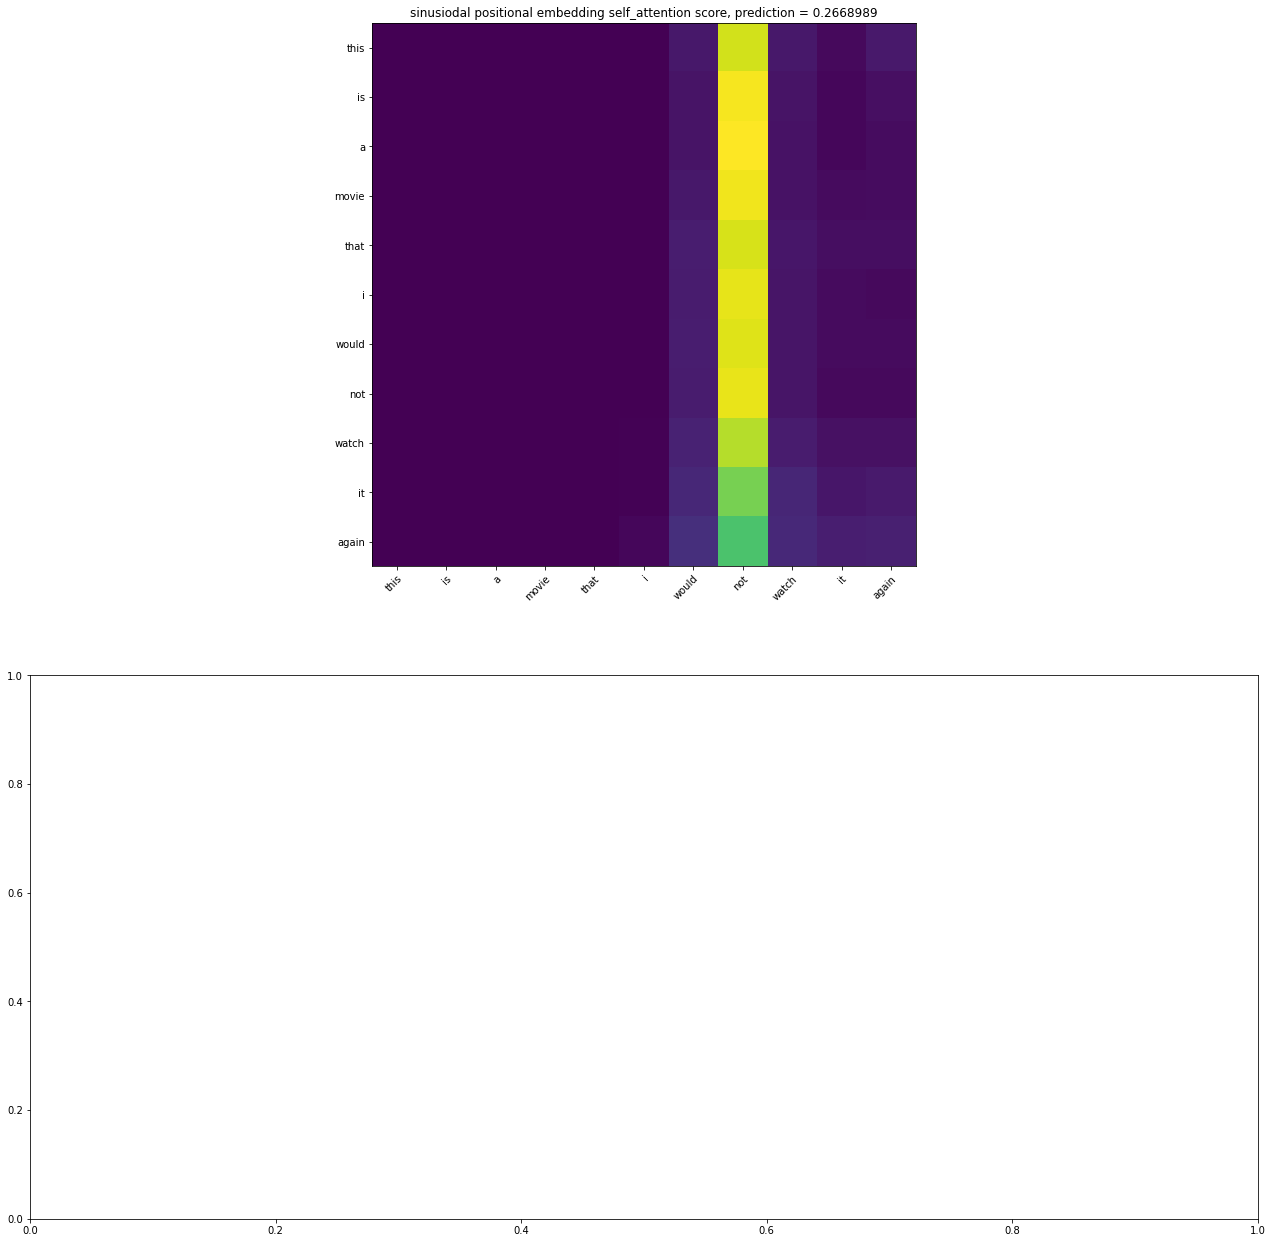

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
import matplotlib.pyplot as plt
#https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


# attn_no_positional = attn_model_no_positional.get_model_layer(1)

# emb,pos_emb,att
vis = Attension_visulaizer(emb, att,pos_emb = None,sinusiodal_positional_encoding_layer = sinusiodal_positional_encoding_layer, sin = True  )
actual_text = text
vis.evaluateAndShowAttention(actual_text, attension_heads = None,msg = "sinusiodal positional embedding self_attention score, prediction = 0.2668989")